## Imports

In [33]:
import os
from functools import partial
import json
import csv

from PIL import Image, ImageDraw
import glob

import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook

from gerrychain import (
    Election,
    Graph,
    MarkovChain,
    Partition,
    accept,
    constraints,
    updaters,
)

from gerrychain.metrics import efficiency_gap, mean_median, partisan_gini
from gerrychain.proposals import recom
from gerrychain.updaters import cut_edges
from gerrychain.tree import recursive_tree_part

## Functions

Only num_feasible_districts is fully done — right now, we need to run make_pngs before max_partisan_districts because of directory issues. To make gifs, run make_pngs and then run make_gifs.

In [48]:
def num_feasible_districts(json_name, num_dists, election):
    
    # Create function-wide variables
    graph = Graph.from_json("./"+json_name+".json")
    TOTPOP = "TOTPOP"
    DEMVOTE = election+"D"
    REPVOTE = election+"R"
    num_precincts = len(graph.nodes)
    
    # Ensure data are integers
    for n in graph.nodes:
        if type(graph.nodes[n][DEMVOTE]) != int:
            graph.nodes[n][DEMVOTE] = int(graph.nodes[n][DEMVOTE].replace(",", ""))
        if type(graph.nodes[n][REPVOTE]) != int:
            graph.nodes[n][REPVOTE] = int(graph.nodes[n][REPVOTE].replace(",", ""))
        
    # Function to calculate population given a .json graph:
    def population_grabber(graph):
        pop_count = 0
        for i in graph.nodes:
            pop_count += graph.nodes[i][TOTPOP]
        pop_count = np.round(pop_count)
        return pop_count
    
    # Compute the ideal population for a district
    I = population_grabber(graph) / num_dists
    
    # Create lists of total pop, dem, and rep voters per precinct
    prec_pop = []
    prec_dem = []
    prec_rep = []
    for n in graph.nodes:
        prec_pop.append(graph.nodes[n][TOTPOP])
        prec_rep.append(graph.nodes[n][REPVOTE])
        prec_dem.append(graph.nodes[n][DEMVOTE])
        
    # We will compute statistics with respect to each party — these stats differ by a factor of -1,
    # hence the for loop iterating over party_list
    party_list = [1, -1]
    
    # Make two 2-element lists, where the first element in each is the number of feasible/infeasible
    # districts for the Republicans, and the second element is the same for the Democrats
    feasible = []
    infeasible = []
    
    for p in party_list: 
        
        # Metric function takes the index of a precinct as input and outputs the party per capita value
        def metric(i):
            if prec_pop[i] == 0:
                return 0
            else:
                return p*((prec_rep[i] - prec_dem[i]) / prec_pop[i])
        
        # Put these party per capita values in a list of two element lists (deltas),
        # then sort them in descending metric order, keeping metrics connected to precinct index
        deltas = []
        for i in range(num_precincts):
            deltas.append([metric(i), prec_pop[i]])
            deltas.sort(key=lambda x:x[0], reverse=True)
            
        # Separate the two element lists inside of deltas into two separate lists
        d = []
        p = []
        for i in range(num_precincts):
            d.append(deltas[i][0])
            p.append(deltas[i][1])

        # Greedily create sets of people that are pro-R/D by drawing from the largest 
        # party per capita precincts first
        quasi_dist_pop = 0
        for i in range(num_precincts):
            if sum(d[:i+1]) > 0:
                quasi_dist_pop += p[i]

        quasi_dist_pop = np.round(quasi_dist_pop)
        
        # Calculate how many districts-worth of people our quasi_dist_pop number is
        possible_districts = quasi_dist_pop / I
        
        # Use this possible districts number to find out the number of feasible/infeasible districts 
        # there are that are pro R/D...this part is not entirely mathematically correct...
        # How do we include the case where it's unknown?
        feasible.append(np.floor(possible_districts))
        infeasible.append(np.ceil(possible_districts))
    
    # Print out results for each party
    print("Republican situation:")
    if feasible[0] == num_dists:
        print("Feasible to have",feasible[0],"districts")
    else:
        print("Feasible to have",feasible[0],"districts")
        print("Not feasible to have",infeasible[0],"districts")
        
    print("Democratic situation:")
    if feasible[1] == num_dists:
        print("Feasible to have",feasible[1],"districts")
    else:
        print("Feasible to have",feasible[1],"districts")
        print("Not feasible to have",infeasible[1],"districts")

In [49]:
num_feasible_districts("massachusetts", 9, "SEN14")

Republican situation:
Feasible to have 3.0 districts
Not feasible to have 4.0 districts
Democratic situation:
Feasible to have 9.0 districts


In [69]:
def max_partisan_districts(json_name, shp_name, num_dists, election, D):
    
    # Create function-wide variables
    graph = Graph.from_json("./"+json_name+".json")
    TOTPOP = "TOTPOP"
    DEMVOTE = election+"D"
    REPVOTE = election+"R"
    num_precincts = len(graph.nodes)
    
    # Ensure data are integers
    for n in graph.nodes:
        if type(graph.nodes[n][DEMVOTE]) != int:
            graph.nodes[n][DEMVOTE] = int(graph.nodes[n][DEMVOTE].replace(",", ""))
        if type(graph.nodes[n][REPVOTE]) != int:
            graph.nodes[n][REPVOTE] = int(graph.nodes[n][REPVOTE].replace(",", ""))
        
   # Function to calculate population given a .json graph:
    def population_grabber(graph):
        pop_count = 0
        for i in graph.nodes:
            pop_count += graph.nodes[i][TOTPOP]
        pop_count = np.round(pop_count)
        return pop_count
    
    # Compute the ideal population for a district
    I = population_grabber(graph) / num_dists
    
    # Create lists of total pop, dem, and rep voters per precinct
    prec_pop = []
    prec_dem = []
    prec_rep = []
    for n in graph.nodes:
        prec_pop.append(graph.nodes[n][TOTPOP])
        prec_rep.append(graph.nodes[n][REPVOTE])
        prec_dem.append(graph.nodes[n][DEMVOTE])
        
    # Create a sorted list of deltas according to a specific, hard-coded metric
    vote_shares = []
    deltas = []
    for i in range(num_precincts):
        if prec_pop[i] != 0:
            deltas.append([(prec_rep[i] - prec_dem[i]) / prec_pop[i], i])     
    
    # Sort the deltas list to be in the right order depending on which party we want to look at
    dem_deltas = sorted(deltas, reverse = False)
    rep_deltas = sorted(deltas, reverse = True)
    
    # Initialize lists to hold nodes of precincts that will be in districts of maximum partisanship
    dem_node_list = []
    rep_node_list = []
    dem_vote_shares = []
    rep_vote_shares = [] 
    
    # Code in this for loop will use "party" to mean either rep or dem...it will first do everything
    # with respect to the Republicans, then the Democrats
    for i in [1,2]:
        if i == 1:
            party_deltas = rep_deltas
            party_node_list = rep_node_list
            party_vote_shares = rep_vote_shares
        else:
            party_deltas = dem_deltas
            party_node_list = dem_node_list
            party_vote_shares = dem_vote_shares

        # Greedily add precincts up precincts to create districts of maximum partisanship. D districts
        # will be made, so we will add up as many precincts until we have enough people for one district,
        # then move on to the next district. We will store the precincts in the node_list as 2-element lists,
        # where the second element is the district number (from 0 to D-1)
        pop_counter = 0
        for i in range(num_precincts):
            for j in range(D):
                if j*I <= pop_counter < (j+1)*I:
                    party_node_list.append([party_deltas[i][1], j])
                    pop_counter += graph.nodes[party_deltas[i][1]][TOTPOP]
        
        # Initialize lists that will hold the number of votes, or population for each district of max partisanship
        dem_votes = [0 for j in range(D)]
        rep_votes = [0 for j in range(D)]
        total_pop = [0 for j in range(D)]
        ones = [1 for j in range(D)] # Will be used later
        
        # Compute the number of partisan votes and total population for each district
        for j in range(D):
            for m in range(len(party_node_list)):
                if party_node_list[m][1] == j:
                    dem_votes[j] += graph.nodes[party_node_list[m][0]][DEMVOTE]
                    rep_votes[j] += graph.nodes[party_node_list[m][0]][REPVOTE]
                    total_pop[j] += graph.nodes[party_node_list[m][0]][TOTPOP]
        
        # Total votes for each district
        total_votes = [dem_votes[j] + rep_votes[j] for j in range(D)]
        
        # Compute vote shares for each district
        for j in range(D):
            party_vote_shares.append(rep_votes[j] / total_votes[j])
  
    # Show what's going on
    print("Computed",D,"most partisan districts for",json_name)
    
    # Read in the shapefile data as a dataframe
    df = gpd.read_file("./"+shp_name+".shp")
    
    # Create color dictionaries: precincts not in a district of max partisanship will be mapped to -1,
    # while precincts in a district will be mapped to the reciprocal of their district number 
    rep_color_dict = {n:-1 for n in graph.nodes}
    dem_color_dict = {n:-1 for n in graph.nodes}
    
    for n in rep_node_list:
        rep_color_dict[n[0]] = 1/(n[1] + 1) # +1 to avoid dividing by 0  
    for n in dem_node_list:
        dem_color_dict[n[0]] = 1/(n[1] + 1)
                
    # Add color information to the dataframe
    df["rep_regions"] = df.index.map(rep_color_dict)
    df["dem_regions"] = df.index.map(dem_color_dict)
    
    path = os.getcwd()
    
    df.plot(column = "rep_regions", cmap="Reds")
    plt.savefig(path+"/"+json_name+"/Rep_maps/top_Rep_Dists-"+str(D)+".png")

    df.plot(column = "dem_regions", cmap="Blues")
    plt.savefig(path+"/"+json_name+"/Dem_maps/top_Dem_Dists-"+str(D)+".png")
    
    # Return vote shares data so that the make_pngs function can store it as a file
    return rep_vote_shares, np.subtract(ones, dem_vote_shares)

In [65]:
def make_pngs(json_name, shp_name, num_dists, election):
    
    # Create directories to put the .pngs in
    path = os.getcwd()
    os.makedirs(path+"/"+json_name+"/Rep_maps", exist_ok=True)
    os.makedirs(path+"/"+json_name+"/Dem_maps", exist_ok=True)
    
    # Run max_partisan_districts for 0 up to D districts, which will file away a map for each new district
    # Also, keep the final tally of party vote shares
    for i in range(num_dists+1):
        rep_vote_shares, dem_vote_shares = max_partisan_districts(json_name, shp_name, num_dists, election, i)
        
    # Save a copy of the vote shares of the top D most Democratic districts (the first value is most helpful)
    np.savetxt(path+"/"+json_name+"/Rep_shares.dat", rep_vote_shares)
    np.savetxt(path+"/"+json_name+"/Dem_shares.dat", dem_vote_shares)

In [79]:
def make_gifs(json_name, length):
    
    # Create directories to put the .GIFs in
    path = os.getcwd()
    os.makedirs(path+"/"+json_name+"/Rep_GIFS", exist_ok=True)
    os.makedirs(path+"/"+json_name+"/Dem_GIFS", exist_ok=True)
    
    # Create the frames, make a list of all images
    frames = []
    imgs = glob.glob(path+"/"+json_name+"/Rep_maps/*.png")
    print(imgs[0])
    
    # Sort the maps by # of districts
    imgs.sort(key=lambda x: int(x.split('Dists-')[1].split('.png')[0]))
    print(imgs[:0])
    for i in imgs:
        new_frame = Image.open(i)
        frames.append(new_frame)

    # Save into a GIF file that loops forever, with each step taking the length of time the user inputs
    frames[0].save(path+"/"+json_name+"/Rep_GIFS/"+'/Rep_GIF-'+str(length)+'.gif', format='GIF',
                   append_images=frames[1:],
                   save_all=True,
                   duration=length, loop=0)
    
    # Do the same for the Democrats:
    frames = []
    imgs = glob.glob(path+"/"+json_name+"/Dem_maps/*.png")
    imgs.sort(key=lambda x: int(x.split('Dists-')[1].split('.png')[0])) 
    for i in imgs:
        new_frame = Image.open(i)
        frames.append(new_frame)
    frames[0].save(path+"/"+json_name+"/Dem_GIFS/"+'/Dem_GIF-'+str(length)+'.gif', format='GIF',
                   append_images=frames[1:],
                   save_all=True,
                   duration=length, loop=0)

For ri :
The top 0 most Republican quasi-districts possible are [] Republican
The top 0 most Democratic quasi-districts possible are [] Democratic
For ri :
The top 1 most Republican quasi-districts possible are [0.4713537893933687] Republican
The top 1 most Democratic quasi-districts possible are [0.71947973] Democratic
For ri :
The top 2 most Republican quasi-districts possible are [0.4713537893933687, 0.28081057995346237] Republican
The top 2 most Democratic quasi-districts possible are [0.71947973 0.52985854] Democratic


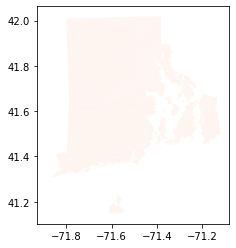

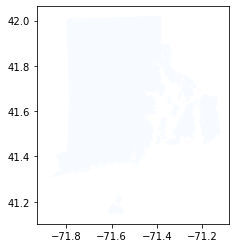

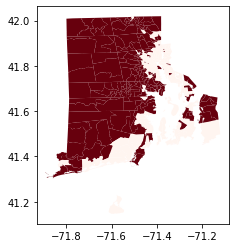

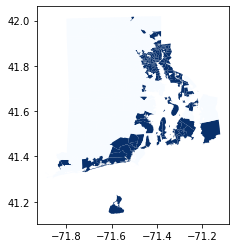

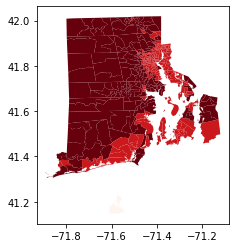

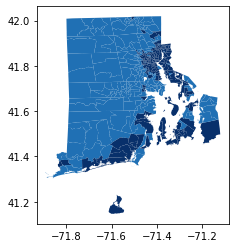

In [44]:
make_pngs("ri", "RI_precincts", 2, "SEN18")

In [43]:
make_gifs("ri", 500)

/Users/gabe/Box Sync/career/mggg_vrdi/Partisan-Metrics/helpful_functions/ri/Rep_maps/top_Rep_Dists-0.png
[]


Computed 0 most partisan districts for massachusetts
Computed 1 most partisan districts for massachusetts
Computed 2 most partisan districts for massachusetts
Computed 3 most partisan districts for massachusetts
Computed 4 most partisan districts for massachusetts
Computed 5 most partisan districts for massachusetts
Computed 6 most partisan districts for massachusetts
Computed 7 most partisan districts for massachusetts
Computed 8 most partisan districts for massachusetts
Computed 9 most partisan districts for massachusetts


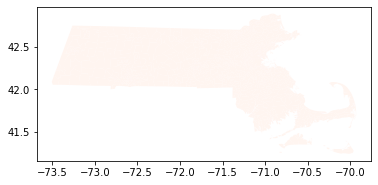

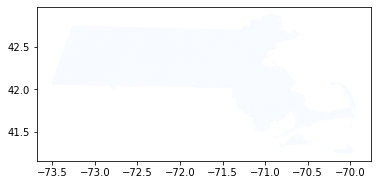

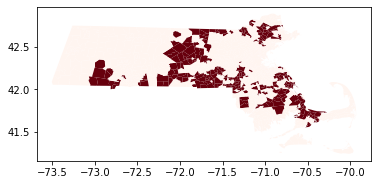

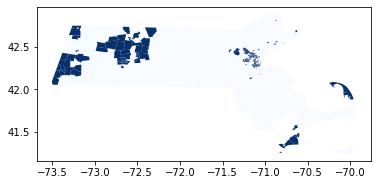

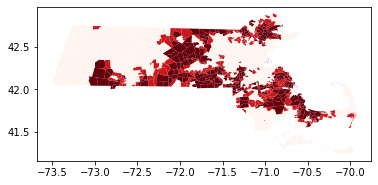

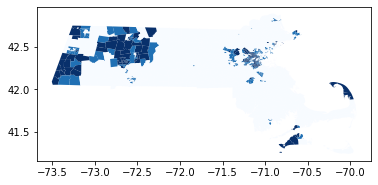

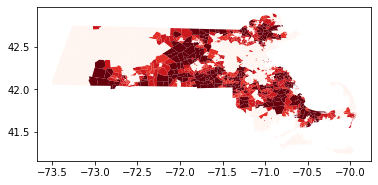

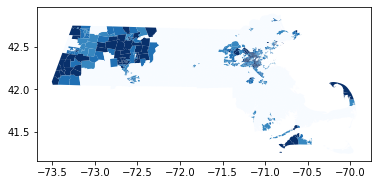

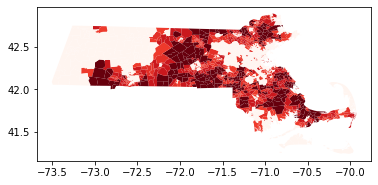

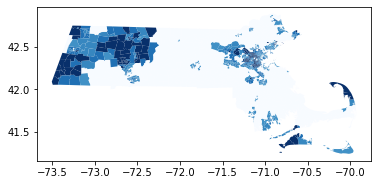

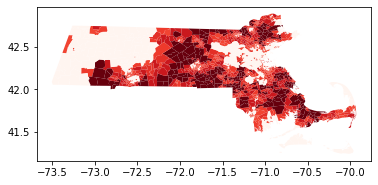

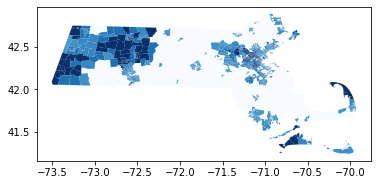

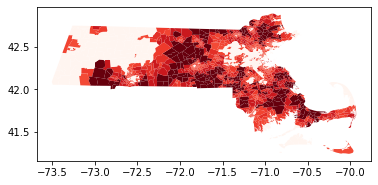

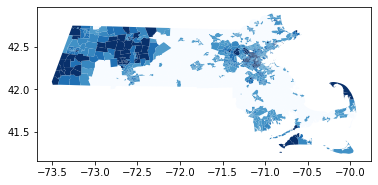

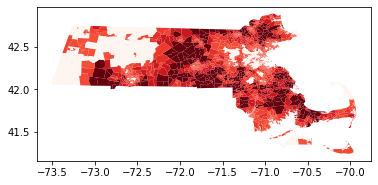

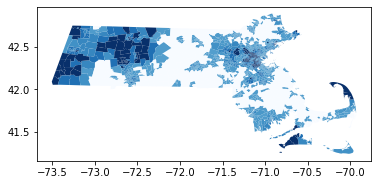

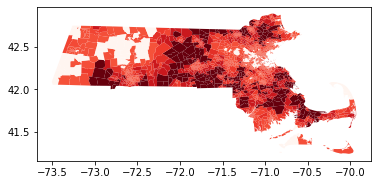

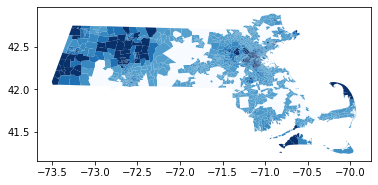

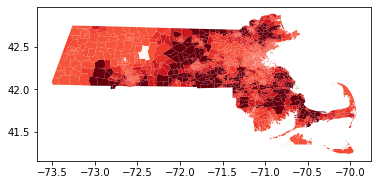

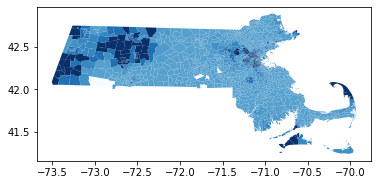

In [70]:
make_pngs("massachusetts", "MA_precincts12_16", 9, "SEN14")

In [75]:
make_gifs("massachusetts", 200)

/Users/gabe/Box Sync/career/mggg_vrdi/Partisan-Metrics/helpful_functions/massachusetts/Rep_maps/top_Rep_Dists-0.png
[]


Computed 0 most partisan districts for utah
Computed 1 most partisan districts for utah
Computed 2 most partisan districts for utah
Computed 3 most partisan districts for utah
Computed 4 most partisan districts for utah


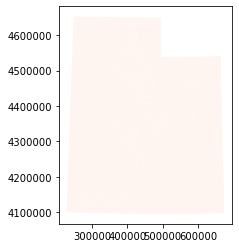

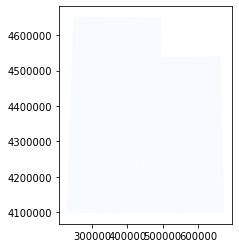

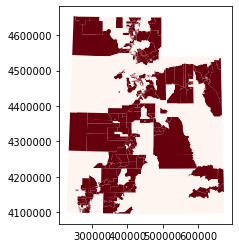

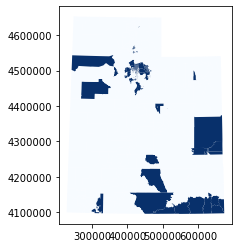

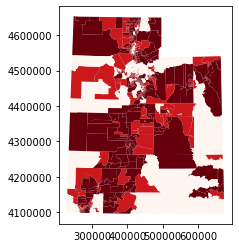

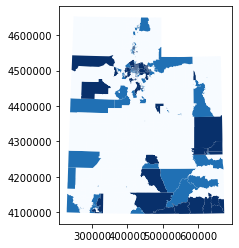

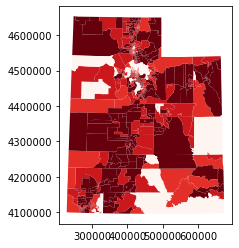

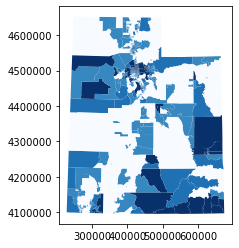

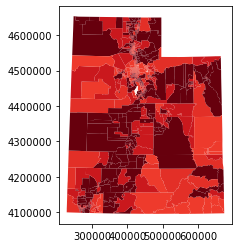

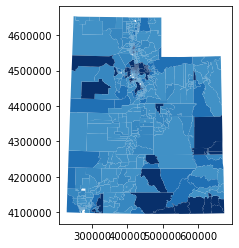

In [76]:
make_pngs("utah", "UT_precincts", 4, "SEN16")

In [78]:
make_gifs("utah", 1000)

/Users/gabe/Box Sync/career/mggg_vrdi/Partisan-Metrics/helpful_functions/utah/Rep_maps/top_Rep_Dists-0.png
[]


Computed 0 most partisan districts for texas
Computed 1 most partisan districts for texas
Computed 2 most partisan districts for texas
Computed 3 most partisan districts for texas
Computed 4 most partisan districts for texas
Computed 5 most partisan districts for texas
Computed 6 most partisan districts for texas
Computed 7 most partisan districts for texas
Computed 8 most partisan districts for texas
Computed 9 most partisan districts for texas
Computed 10 most partisan districts for texas


/miniconda3/envs/VRDI/lib/python3.7/site-packages/geopandas/plotting.py:413: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


Computed 11 most partisan districts for texas
Computed 12 most partisan districts for texas
Computed 13 most partisan districts for texas
Computed 14 most partisan districts for texas
Computed 15 most partisan districts for texas
Computed 16 most partisan districts for texas
Computed 17 most partisan districts for texas
Computed 18 most partisan districts for texas
Computed 19 most partisan districts for texas
Computed 20 most partisan districts for texas
Computed 21 most partisan districts for texas
Computed 22 most partisan districts for texas
Computed 23 most partisan districts for texas
Computed 24 most partisan districts for texas
Computed 25 most partisan districts for texas
Computed 26 most partisan districts for texas
Computed 27 most partisan districts for texas
Computed 28 most partisan districts for texas
Computed 29 most partisan districts for texas
Computed 30 most partisan districts for texas
Computed 31 most partisan districts for texas
Computed 32 most partisan district

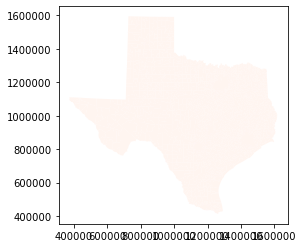

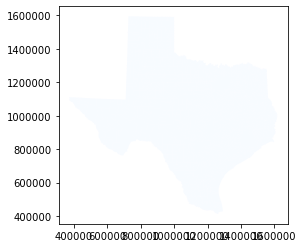

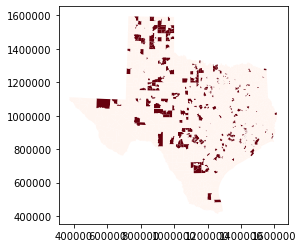

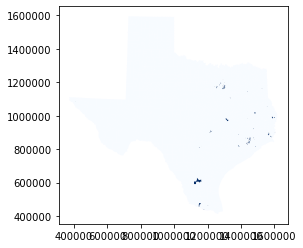

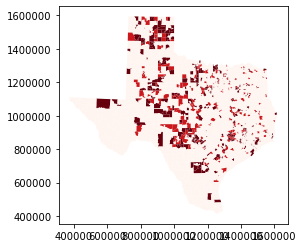

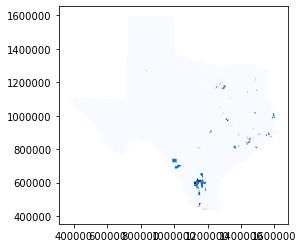

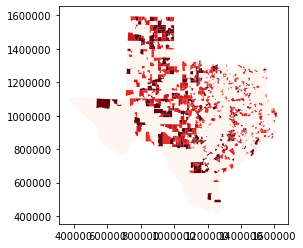

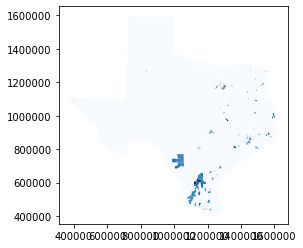

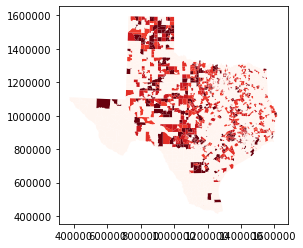

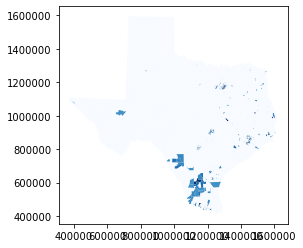

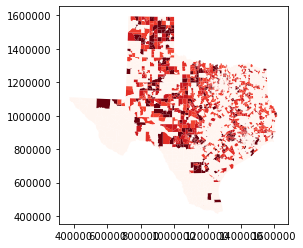

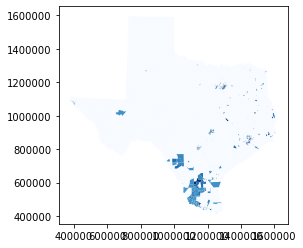

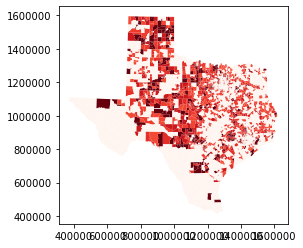

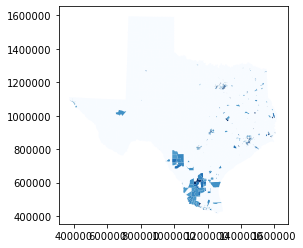

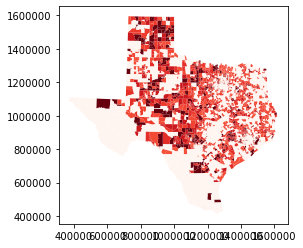

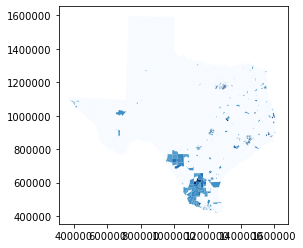

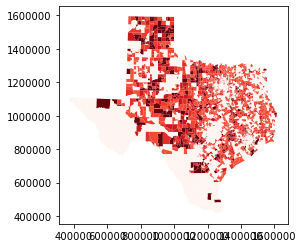

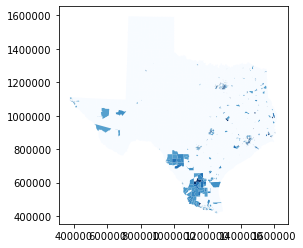

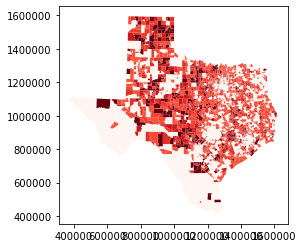

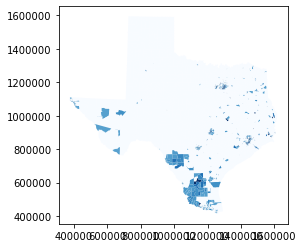

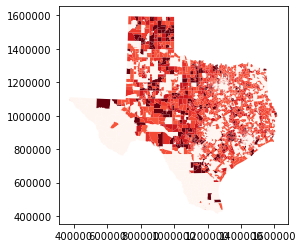

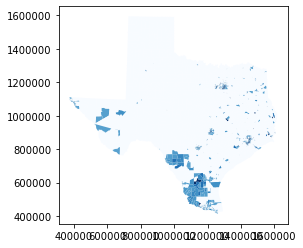

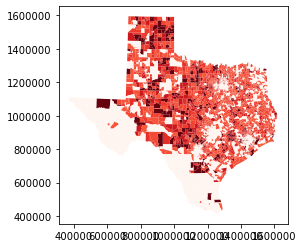

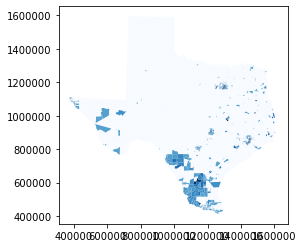

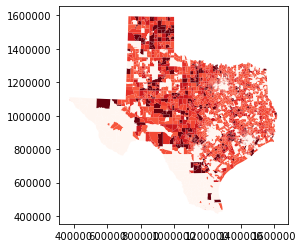

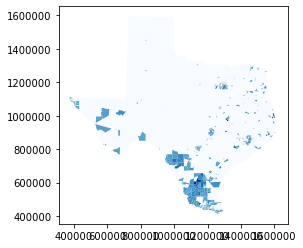

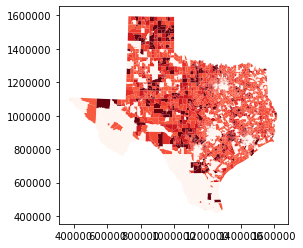

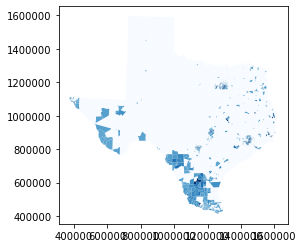

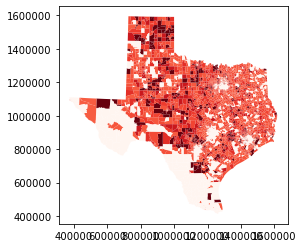

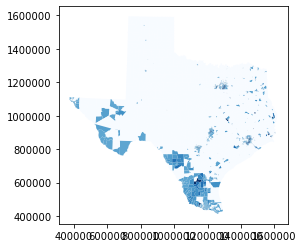

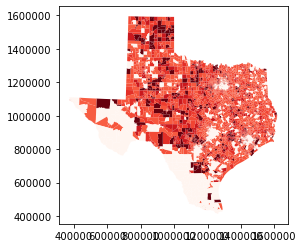

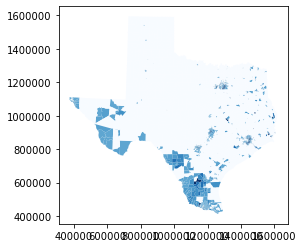

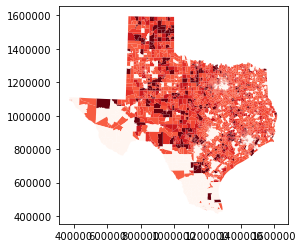

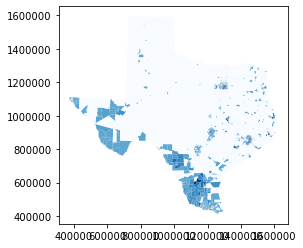

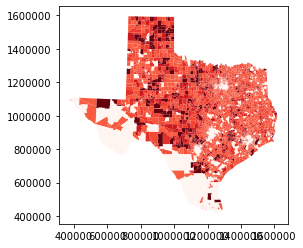

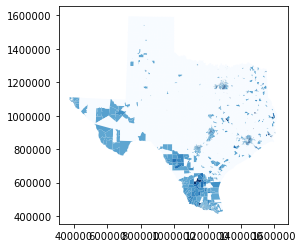

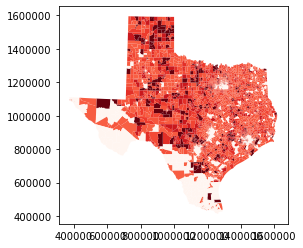

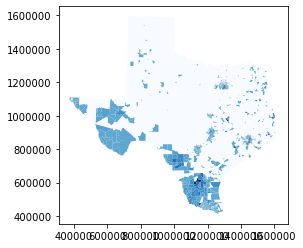

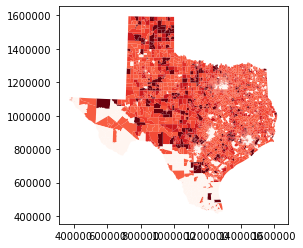

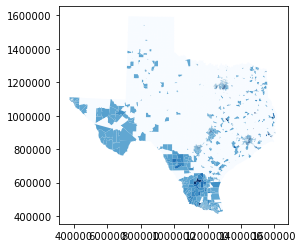

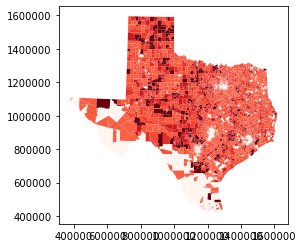

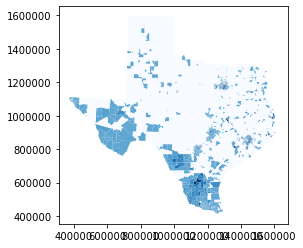

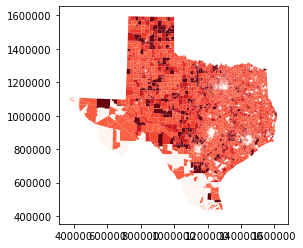

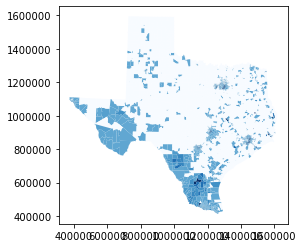

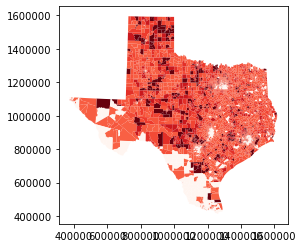

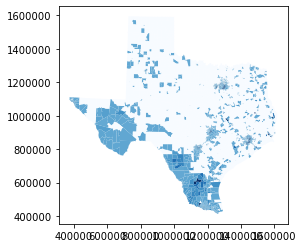

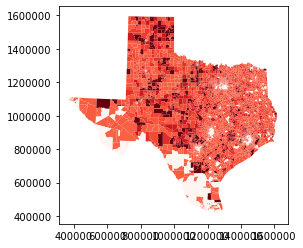

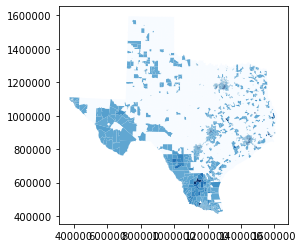

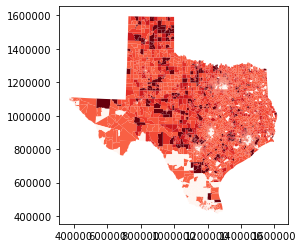

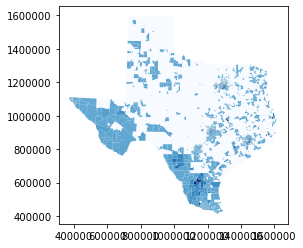

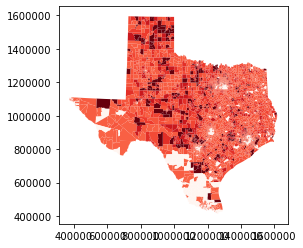

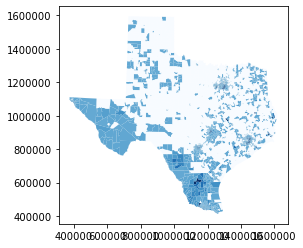

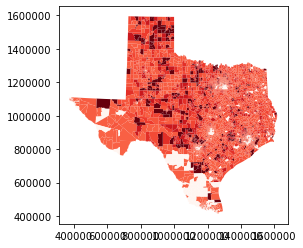

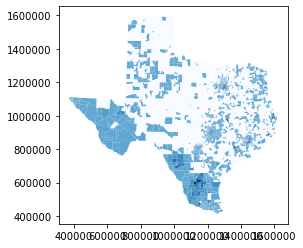

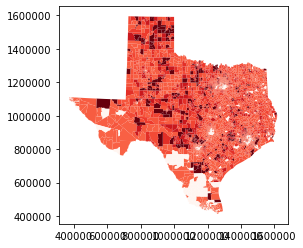

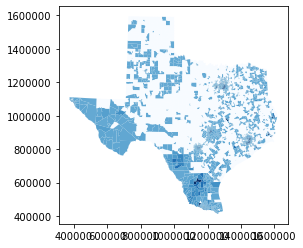

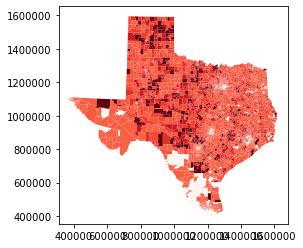

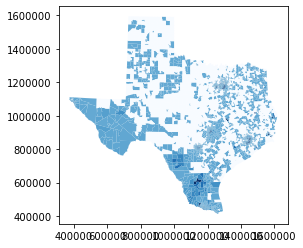

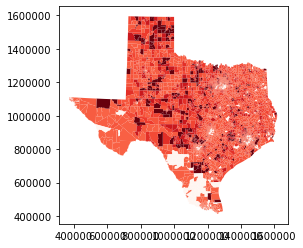

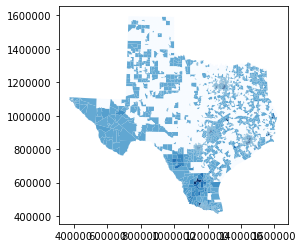

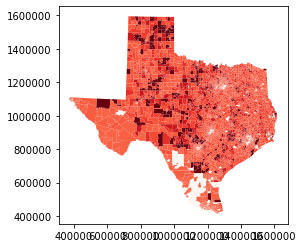

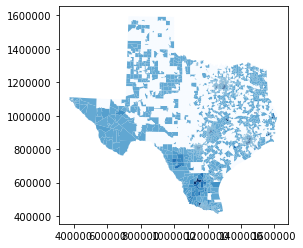

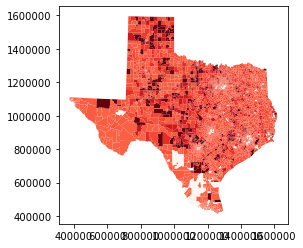

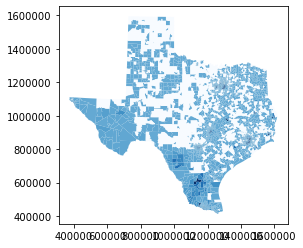

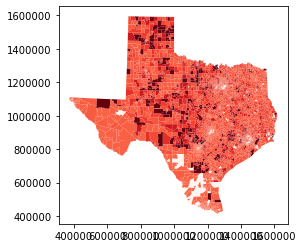

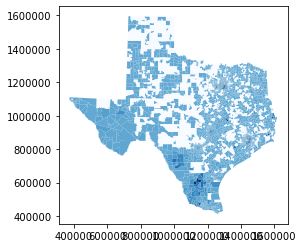

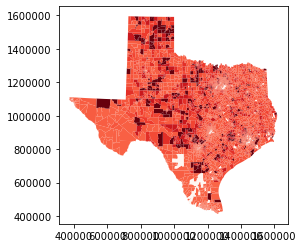

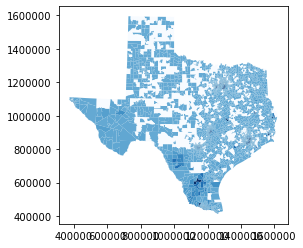

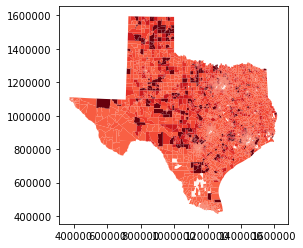

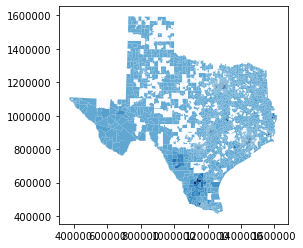

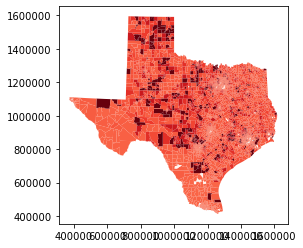

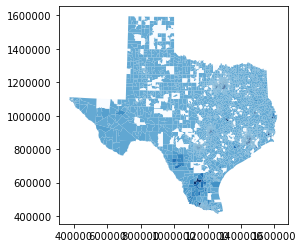

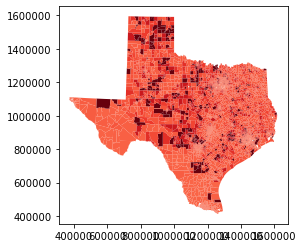

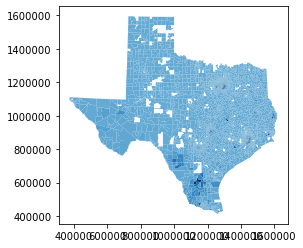

In [80]:
make_pngs("texas", "TX_vtds", 36, "SEN12")

In [81]:
make_gifs("texas", 200)

/Users/gabe/Box Sync/career/mggg_vrdi/Partisan-Metrics/helpful_functions/texas/Rep_maps/top_Rep_Dists-0.png
[]
